# Unigram Mixture model


##### The model :
Recall the unigram mixture model in plate notations :
<img src="img/unigram_mixture_new.png" alt="unigram mixture" width="200"/>

To sample from this model :

First, we have to sample the topic of a document as a one-hot vector, from a multinomial of size $K$.
- $z \sim \mathcal{M}(1, (\pi_1, \dots, \pi_K)), z\in\{0, 1\}^K$
- $p(z)=\prod_{k=1}^K\pi_k^{z_k}$

Once the topic $z^{(i)}$ is selected for document $i$, we can the $N$ words of each documents from a multinomial of size $d$, which is the vocabulary size.
- $w^{(i)}_n~|~\{z^{(i)}_k = 1\} \sim \mathcal{M}(1, (b_{1k},\dots,b_{dk}))$



Finally :
$\displaystyle{p(w^{(i)}, z^{(i)}) = \prod_{k=1}^K \Big[\pi_k^{z_k}\prod_{j=1}^d \prod_{n=1}^{N}b_{jk}^{w^{(i)}_{n,j}z_k}\Big]}$

### Question 0:
Let $x^{(i)}_j=\sum_{n=1}^N w_{nj}^{(i)}$. What is the distribution of $x^{(i)}~|~\{z^{(i)}_k = 1\}$ ?

In the rest of the session, we will work with word counts $x^{(i)}$ as done in the slides.

### Ans0:
knowing that  $w^{(i)}_n~|~\{z^{(i)}_k = 1\} \sim \mathcal{M}(1, (b_{1k},\dots,b_{dk}))$.
Therefore, $x^{(i)}_j$ which is a sum of ${N}$ multinomial distribution is also a multinomial distribution described as follows: $x^{(i)}_j~\sim \mathcal{M}(N, (b_{1k},\dots,b_{dk}))$

### Question 1:
Sample $M=400$ documents of $N=30$ words from the given $\pi$ and $b$ in the next cell. We have $d=3$ words, but $K=6$ topics.
Complete the function _gen_\__corpus_ below that takes all the required parameters as input, and returns a $(M,d)$ array containg the $x^{(i)}$, as well as an $(M,)$ array containing the topics associated with these documents.

In [1]:
import numpy as np
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


n_docs = 400
doc_length = 30
n_topics = 6
n_tokens = 3 # size of the dictionary

topic_proba = np.array([1./n_topics] * n_topics)
word_proba = np.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8],
    [0.45, 0.45, 0.1],
    [0.1, 0.45, 0.45],
    [0.45, 0.1, 0.45]
])


# WARNING: word_proba and corpus are transposed versions of B and X seen in class.
def gen_corpus(n_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba):
    """
    n_docs: number of documents, S
    n_topics: number of topics, K
    doc_length: number of words per documents, N
    topic_proba: (K,) array containing the pi_k
    word_proba: (K, d) array containing the b_{k,j}.
    
    returns: 
    corpus: (M, D) array containing the word counts for each documents
    topics: (M, K) array containing one-hot vectors for the topic of each document
    """
    corpus = np.empty((n_docs, n_tokens))
    topics =np.random.multinomial(1,topic_proba, size=n_docs)

    # For each document, sample the word counts x corresponding to the sampled topic
    for doc_id, topic in enumerate(topics):
        # topic is a one-hot vector, use `where` to find where the 1 is
        topic_id = np.where(topic)[0][0]
        
        corpus[doc_id]= np.random.multinomial(doc_length,word_proba[topic_id])
        #pass  # TODO: Sample the count of words according to topic_id.
    
    return corpus, topics

corpus, topics = gen_corpus(n_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)

### Visualizing the data :
In the next cell, we propose a visualization of this corpus. We will use the three vertices of a triangle to represent our three tokens. A document will be represented as a convex combination of the three vertices. We will color each document according to their topic (red, green, blue and black).
Finally, each row in $b$ giving the token probability given the topic will also be visualized.

### Question 2:
Run the next cell to visualize the dataset. Explain what is shown in the obtained figure.

### Ans 2

We observe that our dataset is composed  by Six clusters ( Green, Blue,Red,yellow,Black and Sky Blue). In the case of this tutorial, we can understand it like the documents of our datset belong to 6 differents topics.

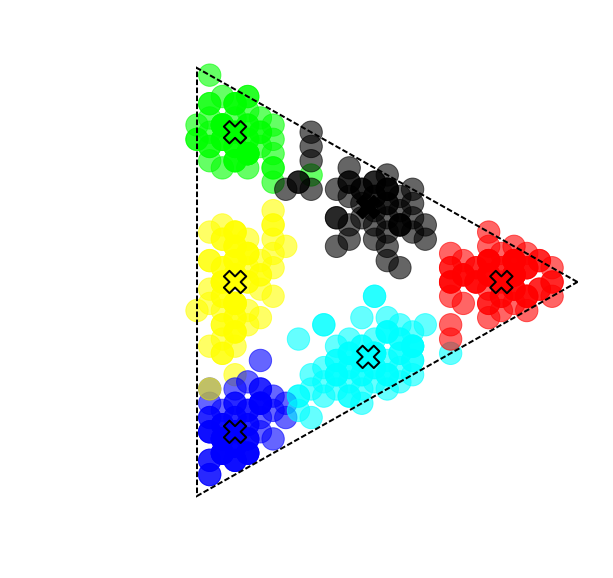

In [2]:
%matplotlib inline
import math

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Compute the triangle vertices using complex roots of 1
vertex_ids = np.array(range(n_tokens))
vertices = np.vstack([
    np.cos(2 * math.pi * vertex_ids / n_tokens),
    np.sin(2 * math.pi * vertex_ids / n_tokens)]
).T

# Plot the triangle
fig, ax = plt.subplots(figsize=(10, 10))
polygon = Polygon(vertices, fill=False, linewidth=2, linestyle='--')
ax.add_patch(polygon)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# Compute a S x 2 array containing documents as linear combination of our vertices

linear_combinations = (corpus / np.sum(corpus, axis=1)[:, None]) @ vertices  
colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0], [1, 1, 0], [0, 1, 1]])

plt.scatter(
    linear_combinations[:, 0], linear_combinations[:, 1], c=np.array(topics) @ colors,
    marker='o', s=500, alpha=0.6
)

centers = word_proba @ vertices

plt.scatter(
    centers[:, 0], centers[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)

plt.axis('off')

plt.show()

We observe documents $(x^{(i)})_{i=1..M}$, and apply EM for $t=1\dots T$.


##### E-Step:
- $\displaystyle{p(z^{(i)}_k=1~|~x^{(i)};b^{(t-1)};\pi^{(t-1)}) = \frac{\pi^{(t-1)}_k \prod_{j=1}^d(b_{jk}^{(t-1)})^{x_j}}{\sum_{k'=1}^K\pi^{(t-1)}_{k'}\prod_{j=1}^d(b_{jk'}^{(t-1)})^{x_j}}}$
- $q^{(t)}_{ik} = \mathbb{E}[z_k~|~x^{(i)};b^{(t)};\pi^{(t)}]$


##### M-Step:
- $\displaystyle{b_{jk}^{(t)} = \frac{\sum_{i}x_j^{(i)}q_{ik}^{(t)}}{\sum_{i,j'}x_{j'}^{(i)}q_{ik}^{(t)}}}$ and $\displaystyle{\pi_{k}^{(t)} = \frac{\sum_{i}q_{ik}^{(t)}}{\sum_{i,k'}q_{ik'}^{(t)}}}$


### Question 3:
1. Re-derive the above formula for $b^{(t)}_{jk}$ starting from the expected complete log-likelihood :
$$\mathbb{E}_{q_i^{(t)}}[\log(p(X, Z;b,\pi)]=\sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk}) + \sum_{i,k}q_{ik}^{(t)}\log(\pi_k) + \tilde{c}$$
2. It could happen in the computation of $q_{ik}^{(t)}$ that both numerator and denominator are very small. To avoid any numerical underflows, we will compute $\log(q_{ik}^{(t)})$ from the logarithms of both numerator and denominator. We use the function logsumexp defined below to compute the denominator from the logarithms of the terms in the sum. Explain why we factored out the maximal value on each row ? 
3. Write code for logsumexp which computes $\log(\sum_i\exp(x_i))$, beware of (2.). Write a test that shows the implementation works as expected. How can we use this function in the E step ?
4. Fill in the code for the E and M steps.

#### Answers

### Ans 3.2:  

#### Avoid Numerical precision errors. 
Indeed, numerator and denominator often have small values and by applying the logarithm this will cancel the values. But by factoring out the maximum value and applying the logarithm, we will have the sum of the terms and therefore we are sure that all the terms will not cancel each other out.

Let's say we have an n-dimensional vector and want to calculate:
$$y = log \sum_{i=1}^{n} e^{x_i}$$
if we try to calculate it naively, we quite quickly will encounter underflows or overflows, depending on the scale of $x_i$. the limited precision of computers is not enough and the result will be INF or -INF. With the log-sum-exp trick : 
$$log \sum_{i=1}^{n} e^{x_i} = a + log \sum_{i=1}^{n} e^{x_i - a}$$

For an arbitrary a . This means, we can shift the center of the exponential sum. A typical value is setting a to the maximum, which forces the greatest value to be zero and even if the other values would underflow, we get a reasonable result: $$a = max( x_i)$$
### Ans 3.3: 
In E step we are computing the logoarithm of the following expression: $\displaystyle {\frac{\pi^{(t-1)}_k \prod_{j=1}^d(b_{jk}^{(t-1)})^{x_j}}{\sum_{k'=1}^K\pi^{(t-1)}_{k'}\prod_{j=1}^d(b_{jk'}^{(t-1)})^{x_j}}}$  . we can see that, after applying the logarithme we will need the function logsumexp  to compute the denominator.(Details on paper)

In [3]:
def logsumexp(x):
    """
    x: a (n, m) array.
    return: log(sum(exp(x_i,:))) for all i, avoiding numerical underflow
    """
    # select the maximum on each row
    max_per_line = x.max(-1)
    res = max_per_line + np.log(np.sum(np.exp(x-max_per_line[:,None]),-1))
    return res

# test that our function does what it should on simple inputs
x = np.array([[1, 2, 3], [2, 2, 2]]) 
print(logsumexp(x), np.log(np.sum(np.exp(x), axis=1)))

# write a test case in which the basic method overflows and yours doesn't
x = np.array([[-1000,-2000,-1000], [-3000,-4000,-2000]]) 
print(logsumexp(x), np.log(np.sum(np.exp(x), axis=1))) # 


def E_step(corpus, learned_topic_proba, learned_word_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    returns : doc_topic_proba : (S, n_topicdlhkfiidgninkhvulrjvurlvhrdekcur) the q_ik
    """
    # TODO: complete
    A= np.log(learned_topic_proba) + corpus @((np.log(learned_word_proba.T)))
    B= logsumexp(A)[:,None]
    Q= A-B
    return np.exp(Q)

def M_step(corpus, doc_topic_probas):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    doc_topic_probas : (S, n_topics) array containing q_ik computed in the E-step
    """

    B= (corpus.T @ doc_topic_probas)/np.sum(corpus.T @ doc_topic_probas, axis=0)
    P_k= doc_topic_probas.sum(axis=0)/ np.sum(doc_topic_probas)
    return P_k, B.T

[3.40760596 3.09861229] [3.40760596 3.09861229]
[ -999.30685282 -2000.        ] [-inf -inf]


In [4]:
a=E_step(corpus,topic_proba,word_proba)
pi,b= M_step(corpus,a)
np.sum(pi)

0.9999999999999999

In [5]:
b

array([[0.79848087, 0.11248041, 0.08903871],
       [0.10599242, 0.7876122 , 0.10639538],
       [0.10504283, 0.10694422, 0.78801295],
       [0.45101299, 0.4531887 , 0.09579831],
       [0.10580518, 0.44611705, 0.44807777],
       [0.44974761, 0.0949848 , 0.4552676 ]])

### Log-Likelihood
It is convenient to visualize the evolution of the marginal log-likelihood of our parameters during training to make sure it is being maximized.

### Question 4:
1. Prove mathematically that the marginal log-likelihood of the parameters during EM increases at each iteration.
2. Implement the computation of the log-likelihood in the next cell. `log_likelihood_qik` will be used later in the session. Hint : `log_multinomial(corpus)` computes $\tilde{c}$

In [6]:
from scipy.special import gammaln
def log_multinomial(params):
    return gammaln(np.sum(params, axis=1) + 1) - np.sum(gammaln(params + 1), axis=1)

def log_likelihood_q_ik(corpus, doc_topic_probas, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    doc_topic_probas : (S, n_topics) array containing E_q[z] computed in the E-step
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    first_term = corpus @ np.log(learned_word_proba.T)
    first_term[np.isnan(first_term)] = 0
    first_term *= doc_topic_probas
    
    second_term = doc_topic_probas @ np.log(learned_topic_proba)[:, None]
    entropy = np.log(doc_topic_probas) * doc_topic_probas
    entropy[np.isnan(entropy)] = 0
    return (np.sum(first_term) + np.sum(second_term) - np.sum(entropy) + np.sum(log_multinomial(corpus))) / corpus.shape[0]

def log_likelihood(corpus, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    loglikelihood= np.sum(logsumexp(corpus @ np.log(learned_word_proba).T + np.log(learned_topic_proba)))
    ctilde= np.sum(log_multinomial(corpus))
    
    return (loglikelihood + ctilde)/corpus.shape[0]

In [7]:
log_likelihood(corpus,word_proba,topic_proba)

-5.772738467556515

### Running EM :
We can now run the Expectation-Maximization algorithm on our corpus.
We will initialize the algorithm by setting $\pi_k = 1/K$.
For $b_{k}$, we use the proportions of random documents.
Then we run the algorithm for a few iterations.

Upon completion, we plot the log likelihood curve for training and validation data.

### Question 5:
- Fill the TODOs in the code, and comment the results when asked.

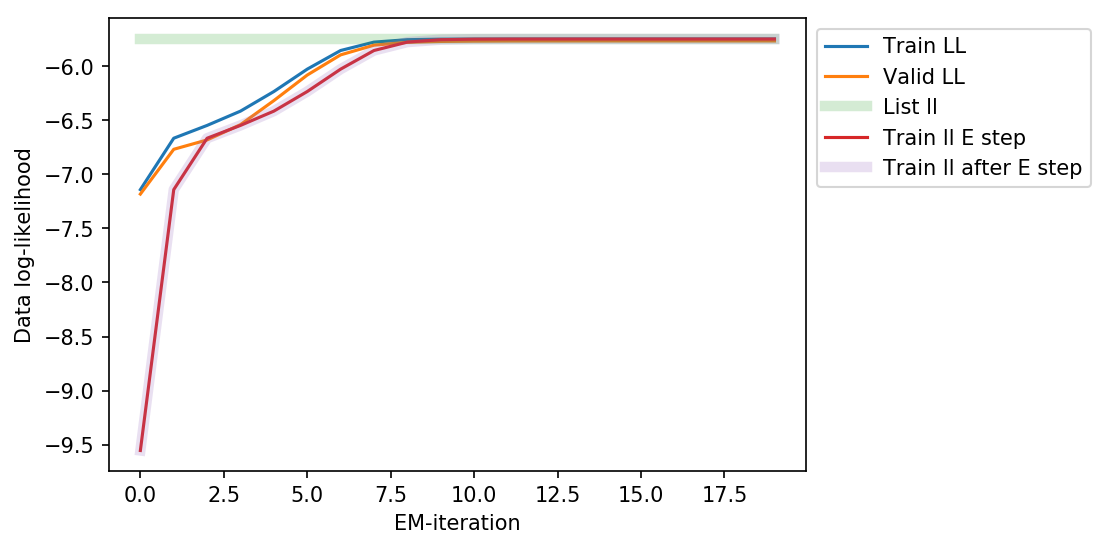

In [8]:
valid_corpus, valid_topics = gen_corpus(1000, n_topics, n_tokens, doc_length, topic_proba, word_proba)

n_iter = 20
n_learned_topics = 6

# We nitialize the learned parameter
# uniform topic proba
learned_topic_proba = np.ones((n_learned_topics,)) / n_learned_topics

# word proba taken from random documents + some constant to avoid zeroes
learned_word_proba = corpus[np.random.permutation(n_docs)[:n_learned_topics]] + 1e-3
learned_word_proba = learned_word_proba / np.sum(learned_word_proba, axis=1)[:, None]

plt.figure(dpi=150)
train_ll = []
train_ll_after_E = []
train_ll_E_step = []
valid_ll = []
for i in range(n_iter):
    # TODO: step of the EM algorithm
    doc_topic_probas= E_step(corpus, learned_topic_proba, learned_word_proba)
    
    # TODO: After E-step call log_likelihood_q_ik on the training data and append this value to train_ll_E_step
    train_ll_E_step.append(log_likelihood_q_ik(corpus,doc_topic_probas, learned_word_proba, learned_topic_proba))
    
    # TODO: After E-step, also call log_likelihood on the training data and  append this value to train_ll_after_E
    train_ll_after_E.append(log_likelihood(corpus, learned_word_proba, learned_topic_proba))
    
    # TODO: After M-step compute the log-likelihoods and append these values to train_ll and valid_ll
    learned_topic_proba,learned_word_proba= M_step(corpus,doc_topic_probas)
    train_ll.append(log_likelihood(corpus, learned_word_proba, learned_topic_proba))
    valid_ll.append(log_likelihood(valid_corpus, learned_word_proba, learned_topic_proba))

# compute valid log-likelihood for the true parameters of the model
ll= log_likelihood(valid_corpus,word_proba,topic_proba)
list_ll=[ll]*n_iter

# TODO: plot train_ll, valid_ll, and valid log-likelihood for true parameters. comment
# TODO: plot train_ll, train_ll_E_step, train_ll_after_E. comment
plt.plot(train_ll,label='Train LL')
plt.plot(valid_ll,label='Valid LL')
plt.plot(list_ll, linewidth=5,alpha=0.2, label='List ll')

plt.plot(train_ll_E_step, label= 'Train ll E step')
plt.plot(train_ll_after_E,linewidth=5,alpha=0.2, label= 'Train ll after E step')
    
plt.xlabel("EM-iteration")
plt.ylabel("Data log-likelihood")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()


### Question 6:
Plot the learned word_proba along the dataset and original word_probas. Rerun the code with several different random initializations, comment.

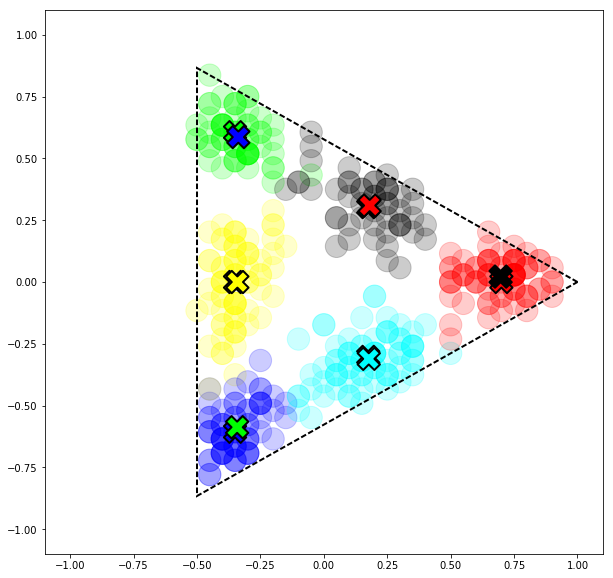

In [9]:
# Plot the triangle
fig, ax = plt.subplots(figsize=(10, 10))
polygon = Polygon(vertices, fill=False, linewidth=2, linestyle='--')
ax.add_patch(polygon)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# Compute a S x 2 array containing documents as linear combination of our vertices
linear_combinations = (corpus / np.sum(corpus, axis=1)[:, None]) @ vertices  

plt.scatter(
    linear_combinations[:, 0], linear_combinations[:, 1], c=np.array(topics) @ colors,
    marker='o', s=500, alpha=0.2
)

# plot real word_proba

centers = word_proba @ vertices

plt.scatter(
    centers[:, 0], centers[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)

centers1 = learned_word_proba @ vertices

plt.scatter(
    centers1[:, 0], centers1[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)

plt.show()

### Larger synthetic dataset

Now, we will generate a more realistic synthetic dataset. We will have $1000$ documents of $200$ words each, $10$ topics and $50$ different tokens.
We will randomly generate the parameters of our generative model with uniform <em>topic_proba</em> and <em>word_proba</em> coming from a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) distribution with all parameters equal to $\alpha=0.5$.

### Question 6:
- How can we determine the right number of topics to model this data ?
- Implement this idea in the following cell.

### Ans6:
 to determine the right number of topics to model data we will use the model selection by following these steps:
 
   - generate the data with the function gen_bigger_corpus
   - create a range of values of topics
   - for each value of topic, learn the parameters of the model and compute the average of the likelihood of all the iterations and store it inside the list
   - at the end, juste to value of topic that gives the maximum value of the likelihood
   


In [10]:
n_train_docs = 100
n_valid_docs = 1000
doc_length = 200
n_topics = 10
n_tokens = 50
alpha = 0.5


def gen_bigger_corpus(
    n_train_docs, n_valid_docs, doc_length,
    n_topics, n_tokens, alpha
):
    topic_proba = np.array([1./n_topics] * n_topics)
    word_proba = np.random.dirichlet([alpha] * n_tokens, size=n_topics)

    corpus, topics = gen_corpus(n_train_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)
    valid_corpus, valid_topics = gen_corpus(n_valid_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)
    
    # This is called smoothing : https://en.wikipedia.org/wiki/Smoothing
    corpus += 1e-5
    valid_corpus += 1e-5
    
    return topic_proba, word_proba, corpus, valid_corpus


# TODO: Implement your method here.
# Use the previous function to generate your dataset

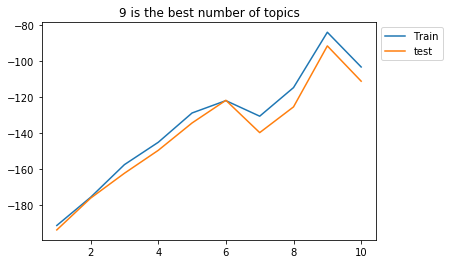

In [11]:
#we will use the log likelihood to determine the best number of topics
big_topic_proba,big_word_proba,Big_corpus,Big_valid_corpus= gen_bigger_corpus(n_train_docs,n_valid_docs,doc_length,n_topics,n_tokens,alpha)
n_iter = 20
bestTopictrain=[]
bestTopictest=[]
for k in range(1,11):
    learned_topic_probat = np.ones((k,))/ k
    learned_word_probat = Big_corpus[np.random.permutation(n_train_docs)[:k]] + 1e-3
    learned_word_probat = learned_word_probat / np.sum(learned_word_probat, axis=1)[:, None]
    
    train_llt = []
    valid_llt = []
    
    
    for i in range(n_iter):
        doc_topic_probast= E_step(Big_corpus, learned_topic_probat, learned_word_probat)
        
        learned_topic_probat,learned_word_probat= M_step(Big_corpus,doc_topic_probast)
        
        train_llt.append(log_likelihood(Big_corpus, learned_word_probat, learned_topic_probat))
        
        valid_llt.append(log_likelihood(Big_valid_corpus, learned_word_probat, learned_topic_probat))

    bestTopictrain.append(np.mean(train_llt))
    bestTopictest.append(np.mean(valid_llt))
top= np.argmax(bestTopictest,axis=0)
plt.title('{} is the best number of topics' .format(top+1) )
plt.plot(np.arange(1,11),bestTopictrain, label='Train')
plt.plot(np.arange(1,11),bestTopictest,label='test')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()

# Application to Text
This model is well suited to represent text. In the following, we will apply our EM algorithm to discover topics in the _newsgroup 20_ corpus.

As is standard in Natural Language Processing, we will first apply a few pre-processing steps to the corpus as described [here](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925).

Make sure you have installed the following libraries into your conda environment : 
- gensim
- nltk
- scikit-learn

First, we download the dataset, and wordnet.

In [12]:
import gensim
import nltk

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.datasets import fetch_20newsgroups

newsgroups = {
    'train': fetch_20newsgroups(subset='train', shuffle = True),
    'test': fetch_20newsgroups(subset='test', shuffle = True)
}
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/belona/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###  Preprocessing :
We use the same pre-processing as in the blog-post :
- **Tokenization** : Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All **stopwords** are removed.
- Words are **lemmatized** - third person is changed to first person, all verbs are changed into present tense
- Words are **stemmed** - words are reduced to their root form.

In [13]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

preprocess("The quick brown fox jumped over the lazy dogs.")

['quick', 'brown', 'jump', 'lazi', 'dog']

### Dictionary making:
Each unique element in the output of _preprocess_ is a token. We need to convert these into unique ids to run our algorithm. This is called building a **dictionary**. The library _gensim_ has a helper function to help us do this.

### Question 7:
- Why is all this preprocessing useful ?

### Ans7
- Cleaning consist of getting rid of the less useful parts of text through stopword removal, dealing with capitalization and characters and other details.

- Normalization consists of the mapping of terms in the scheme or linguistic reductions through Stemming, Lemmazation

In [14]:
processed_docs = {s: [] for s in ['train', 'test']}
# This may take a while. We are processing the entire dataset.
for s in ['train', 'test']:
    for doc in newsgroups[s].data:
        processed_docs[s].append(preprocess(doc))
    
dictionary = gensim.corpora.Dictionary(processed_docs['train'])
print({len(dictionary)}," unique tokens before filtering")
dictionary.filter_extremes(no_below=15, no_above=0.1)
print({len(dictionary)}," unique tokens after filtering")

{61411}  unique tokens before filtering
{6535}  unique tokens after filtering


In [15]:
# transform our corpus of text to lists of counts of tokens
bow_corpus = {
    s: [dictionary.doc2bow(doc) for doc in processed_docs[s]]
    for s in ['train', 'test']
}

n_tokens = len(dictionary)
text_corpus = {'train': None, 'test': None}
for s in text_corpus.keys():
    n_docs = len(processed_docs[s])
    text_corpus[s] = np.zeros((n_docs, n_tokens), dtype='int32')
    for d, bow in enumerate(bow_corpus[s]):
        for (id, value) in bow:
            text_corpus[s][d, id] = value

### Model learning
Now that the dataset is ready run EM on it, using $5$ topics. Since the dataset is bigger, this could take some time.

In [16]:
# New E_step using bag of words rather than dense count arrays
def E_step_sparse(corpus, learned_topic_proba, learned_word_proba):
    n_topics = learned_topic_proba.shape[0]
    res = np.zeros((len(corpus), n_topics))
    for d, tuples in enumerate(corpus):
        maxi = np.finfo('float64').min
        for topic in range(n_topics):
            cur = np.log(learned_topic_proba[topic])
            for tok_id, v in tuples:
                tok_prob = learned_word_proba[topic, tok_id]
                cur += np.log(tok_prob) * v
            res[d, topic] = cur
            maxi = max(maxi, cur)
        total = 0
        for topic in range(n_topics):
            total += np.exp(res[d, topic] - maxi)
            res[d, topic] = np.exp(res[d, topic] - maxi)
        res[d, :] /= total

    return res

In [17]:
# New log_likelihood to deal with NaNs
def log_likelihood(corpus, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    all_products = np.log(learned_word_proba[None, :, :]) * corpus[:, None, :]
    all_products[np.isnan(all_products)] = 0
    A = np.sum(all_products, axis=2) + np.log(learned_topic_proba)[None, :] + log_multinomial(corpus)[:, None]
    return np.mean(logsumexp(A))

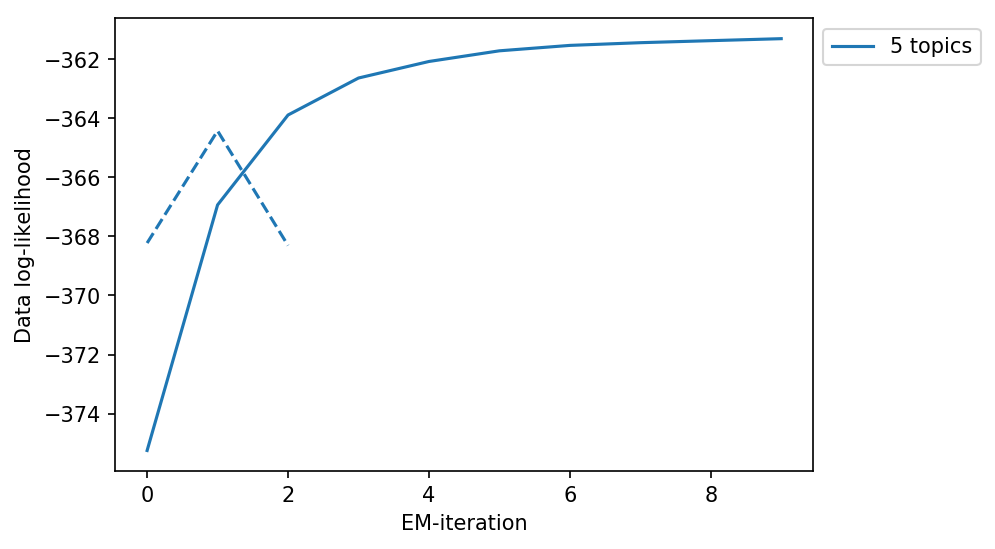

In [18]:
n_iter = 10
n_topics = 5
n_docs = len(bow_corpus['train'])

learned_topic_proba = np.ones((n_topics,)) / n_topics
learned_word_proba = np.empty((n_topics, n_tokens), dtype='float32')
# initialize topic probabilities with random documents
permutation = np.random.permutation(n_docs)
batch_size = n_docs // n_topics
for t in range(n_topics):
    stats = np.sum(text_corpus['train'][permutation[t * batch_size: (t+1) * batch_size]], axis=0)
    learned_word_proba[t] = stats / np.sum(stats)

train_ll = []
valid_ll = []
for i in range(n_iter):
    # E-step
    doc_topic_probas = E_step_sparse(bow_corpus['train'], learned_topic_proba, learned_word_proba)

    # E-step for valid
    valid_topic_probas = E_step_sparse(bow_corpus['test'], learned_topic_proba, learned_word_proba)

    # M-step
    learned_topic_proba, learned_word_proba = M_step(text_corpus['train'], doc_topic_probas)

    train_ll.append(log_likelihood(text_corpus['train'], learned_word_proba, learned_topic_proba))    
    valid_ll.append(log_likelihood(text_corpus['test'], learned_word_proba, learned_topic_proba))
    
plt.figure(dpi=150)
p, = plt.plot(range(len(train_ll)), train_ll, '-', label="{} topics".format(n_topics))
plt.plot(range(len(valid_ll)), valid_ll, '--', c=p.get_color())
    
plt.xlabel("EM-iteration")
plt.ylabel("Data log-likelihood")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()


In [19]:
valid_ll

[-368.22368146094544,
 -364.4231582261035,
 -368.3070597991948,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

### Visualizing the topics

Now that we've run EM, we can print the most frequent terms associated to each topics.

In [20]:
print(learned_topic_proba)
for t in range(n_topics):
    most_frequent = np.argsort(learned_word_proba[t])[-10:]
    print("------- Topic {} ------".format(t))
    for w in most_frequent:
        print("\t -- {}" .format(dictionary[int(w)]))

[0.1727736  0.33388043 0.14161498 0.18290194 0.16882905]
------- Topic 0 ------
	 -- moral
	 -- church
	 -- life
	 -- word
	 -- live
	 -- bibl
	 -- exist
	 -- armenian
	 -- jesus
	 -- christian
------- Topic 1 ------
	 -- disk
	 -- graphic
	 -- scsi
	 -- softwar
	 -- version
	 -- card
	 -- program
	 -- drive
	 -- file
	 -- window
------- Topic 2 ------
	 -- goal
	 -- basebal
	 -- leagu
	 -- score
	 -- season
	 -- hockey
	 -- player
	 -- play
	 -- team
	 -- game
------- Topic 3 ------
	 -- weapon
	 -- gun
	 -- jew
	 -- arab
	 -- live
	 -- american
	 -- kill
	 -- isra
	 -- govern
	 -- israel
------- Topic 4 ------
	 -- public
	 -- program
	 -- clipper
	 -- data
	 -- secur
	 -- govern
	 -- chip
	 -- nasa
	 -- encrypt
	 -- space


### Perplexity
The [perplexity](https://en.wikipedia.org/wiki/Perplexity) of a model $q$ on a test sample $(x_s)$ is given by :
$$2^{-\frac{1}{S}\sum_{s=1}^S\log_2(q(x_s))}$$

### Question 8 :
Explain why this quantity is called perplexity.



### Ans8
This expression can be rewrite as $2^{H}$, where ${H}$ is the entropy of distribution $q$. 
Perplexity is a measure of how easy a probability distribution is to predict.Considering a language model as an information source, it follows that a language model which took advantage of all possible features of language to predict words would also achieve a per-word entropy of $ H$. So,It makes sense to use a measure related to entropy to assess the actual performance of a language model. In other Words, if the Entropy of the model is high , the Perplexity of the model will also be high.

### Bonus Questions :
- In the code implemented for question 6, what happens when we increase the number of documents in the training set ? Comment.
- What can you notice regarding the computations done in the E-M algorithm for this practical session ? How would you implement this algorithm in a distributed fashion ?

### Bonus Answers

    -  If we increase the number of documents in the trainning set, we are reducing the risk to overfit the model and we also give the opportunity to the model to learn more about the features to better understand.

- 